In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
%cd /mydrive/Pytorch-Models
!ls

Mounted at /content/gdrive
/content/gdrive/My Drive/Pytorch-Models
coco_eval.py   FasterRCNN-det.ipynb  SAM.ipynb		   transforms.py
coco_utils.py  MaskRCNN-Seg.ipynb    sam_vit_b_01ec64.pth  utils.py
datasets       __pycache__	     SSD-det.ipynb	   vision
engine.py      requirements.txt      test


In [4]:
import torch
import os
import random
import matplotlib.pyplot as plt
import cv2
import numpy as np

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 2.6.0+cu124 (Tesla T4)


In [8]:
!pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-pxvkkzc4
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-pxvkkzc4
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=241e80ee5bb1c610ff46e5bc7875741226dc383319e7c0b041a78e0624c039f6
  Stored in directory: /tmp/pip-ephem-wheel-cache-o75npjwd/wheels/15/d7/bd/05f5f23b7dcbe70cbc6783b06f12143b0cf1a5da5c7b52dcc5
Successfully built segment_anything


In [5]:
# 📌 Download SAM weights (ViT-B)
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

--2025-06-25 15:04:55--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.210.78, 13.226.210.111, 13.226.210.25, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.226.210.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375042383 (358M) [binary/octet-stream]
Saving to: ‘sam_vit_b_01ec64.pth’

sam_vit_b_01ec64.pt 100%[===================>] 357.67M  73.4MB/s    in 5.1s    

2025-06-25 15:05:00 (69.8 MB/s) - ‘sam_vit_b_01ec64.pth’ saved [375042383/375042383]



In [9]:
image_folder = "datasets/surgical_instruments/images/valid"

In [112]:
def select_random_images(folder_path, desired_num=3):
    all_images = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    total = len(all_images)
    if total == 0:
        print("❌ No images found.")
        return []
    num_samples = min(desired_num, total)
    selected = random.sample(all_images, num_samples)
    print(f"✅ Selected {num_samples} images: {selected}")
    return selected

# ✅ Always 3 if possible:
selected_images = select_random_images(image_folder, desired_num=3)

✅ Selected 3 images: ['Laparoscopic-Surgery-for-Large-Intramural-Fibroid-66-_jpg.rf.f705ebb9fc73505d4506e878ebd3c694.jpg', 'Laparoscopic-Surgery-for-Large-Intramural-Fibroid-301-_jpg.rf.57ac9d7b466027199307e017fa1593be.jpg', 'Laparoscopic-Hysterectomy-with-Ureteral-208-_jpg.rf.cdf62dd079d8fed94e5959d8959aed6b.jpg']


In [20]:
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_b_01ec64.pth"
model_type = "vit_b"

device = "cuda" if torch.cuda.is_available() else "cpu"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)

In [26]:
def show_mask(mask, ax, color=(0, 1, 1), alpha=0.8):
    mask_image = np.zeros((*mask.shape, 4))  # RGBA
    for i in range(3):
        mask_image[:, :, i] = color[i]
    mask_image[:, :, 3] = mask * alpha
    ax.imshow(mask_image, interpolation='none')  # Prevents blur

def show_points(coords, labels, ax, marker_size=375):
    point_colors = ['cyan', 'red', 'green', 'blue', 'yellow']
    for idx, (coord, label) in enumerate(zip(coords, labels)):
        color = point_colors[idx] if idx < len(point_colors) else 'cyan'
        if label == 1:
            ax.scatter(coord[0], coord[1], color=color, marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
        elif label == 0:
            ax.scatter(coord[0], coord[1], color=color, marker='x', s=marker_size, edgecolor='white', linewidth=1.25)

In [180]:
def run_sam_per_point_mask_with_threshold(selected_images, points_dict, threshold=0.5):
    point_colors_rgb = [
        (0, 1, 1),  # Cyan
        (1, 0, 0),  # Red
        (0, 1, 0),  # Green
        (0, 0, 1),  # Blue
        (1, 1, 0),  # Yellow
    ]

    num_images = len(selected_images)
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    for idx in range(3):
        ax = axes[idx]

        if idx < num_images:
            img_name = selected_images[idx]
            image_path = os.path.join(image_folder, img_name)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            predictor.set_image(image)

            if img_name not in points_dict:
                print(f"No points defined for {img_name}. Skipping.")
                ax.axis('off')
                continue

            input_points = points_dict[img_name]["coords"]
            input_labels = points_dict[img_name]["labels"]

            ax.imshow(image)

            for point_idx, (point, label) in enumerate(zip(input_points, input_labels)):
                if label != 1:
                    continue  # Skip background points

                point_array = np.array([point])
                label_array = np.array([label])

                masks, scores, logits = predictor.predict(
                    point_coords=point_array,
                    point_labels=label_array,
                    multimask_output=False,
                )

                prob_mask = 1 / (1 + np.exp(-logits[0]))  # sigmoid on logits

                mean_conf = prob_mask.mean()
                max_conf = prob_mask.max()
                score = scores[0] if scores is not None else None

                print(f"Point {point_idx+1} → mean_conf: {mean_conf:.3f}, max_conf: {max_conf:.3f}, score: {score}")

                # Use mean confidence or score for thresholding
                conf_value = mean_conf if score is None else score

                if conf_value < threshold:
                    print(f"Point {point_idx+1} → Below threshold {threshold}, skipping mask.")
                    continue

                sam_mask = masks[0].astype(np.uint8)  # aligned mask

                color_idx = point_idx % len(point_colors_rgb)
                mask_color_rgb = point_colors_rgb[color_idx]

                show_mask(sam_mask, ax, color=mask_color_rgb)

            show_points(np.array(input_points), np.array(input_labels), ax)
            ax.set_title(f"Image {idx+1} - Thresh filter: {threshold}", fontsize=14)
            ax.axis('off')

        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

Point 1 → mean_conf: 0.039, max_conf: 1.000, score: 0.8840968012809753
Point 2 → mean_conf: 0.037, max_conf: 1.000, score: 0.8643584251403809
Point 1 → mean_conf: 0.019, max_conf: 1.000, score: 0.8921171426773071
Point 2 → mean_conf: 0.029, max_conf: 1.000, score: 0.8847684860229492


/tmp/ipython-input-26-2174880177.py:15: UserWarning: You passed a edgecolor/edgecolors ('white') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(coord[0], coord[1], color=color, marker='x', s=marker_size, edgecolor='white', linewidth=1.25)


Point 1 → mean_conf: 0.012, max_conf: 1.000, score: 0.9261413812637329
Point 2 → mean_conf: 0.017, max_conf: 1.000, score: 0.9848847985267639
Point 3 → mean_conf: 0.022, max_conf: 1.000, score: 0.8223140239715576


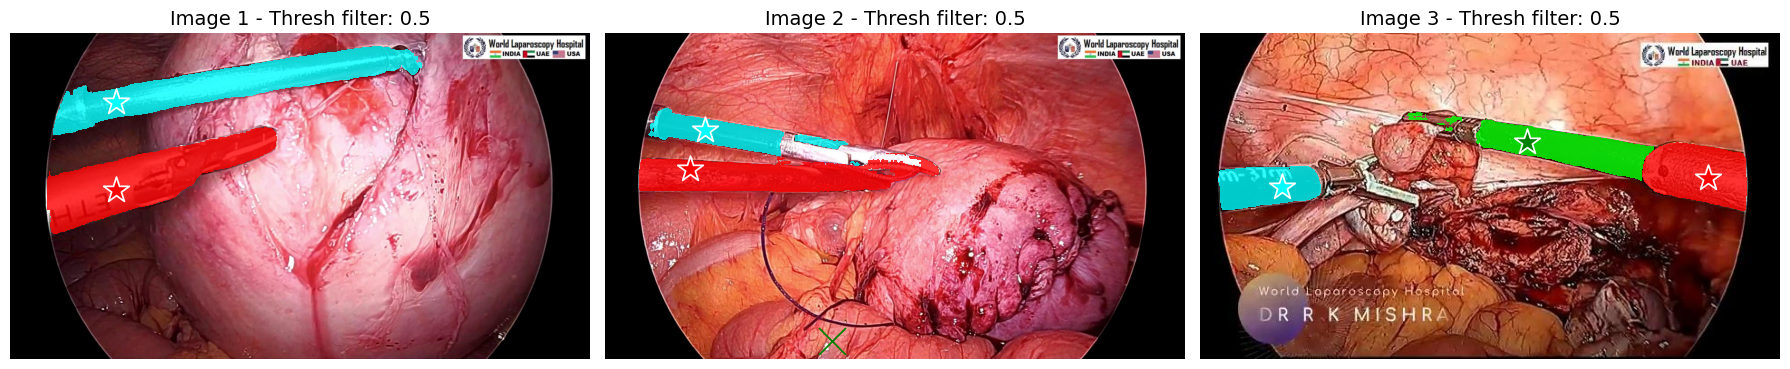

In [181]:
points_for_images = {
    selected_images[0]: {
        "coords": [[350, 230], [350, 520]],  # 2 foreground points
        "labels": [1, 1]
    },
    selected_images[1]: {
        "coords": [[330, 320], [280, 450], [750, 1020]],  # 3 points (could add background label)
        "labels": [1, 1, 0]  # last is background point
    },
    selected_images[2]: {
        "coords": [[90, 170], [560, 160], [360, 120]],  # 3 points (could add background label)
        "labels": [1, 1, 1]  # last is background point
    },
}

# ✅ Run SAM with desired points
run_sam_per_point_mask_with_threshold(selected_images, points_for_images, threshold=0.5)

In [196]:
def run_sam_with_points_and_boxes(selected_images, points_dict, boxes_dict, threshold=0.8, show_grid=False):
    point_colors_rgb = [
        (0, 1, 1),  # Cyan
        (1, 0, 0),  # Red
        (0, 1, 0),  # Green
        (0, 0, 1),  # Blue
        (1, 1, 0),  # Yellow
    ]

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    for idx in range(3):
        ax = axes[idx]

        if idx < len(selected_images):
            img_name = selected_images[idx]
            image_path = os.path.join(image_folder, img_name)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            predictor.set_image(image)

            # Prepare points (if available)
            if img_name in points_dict:
                input_points = points_dict[img_name]["coords"]
                input_labels = points_dict[img_name]["labels"]
                point_array = np.array(input_points)
                label_array = np.array(input_labels)
            else:
                point_array = None
                label_array = None

            # Prepare boxes (allow multiple boxes)
            if img_name in boxes_dict:
                boxes = boxes_dict[img_name]
                if isinstance(boxes, np.ndarray) and boxes.ndim == 1:
                    boxes = [boxes]
            else:
                boxes = [None]  # Run once without box

            # Skip if no points and no boxes
            if point_array is None and all(b is None for b in boxes):
                print(f"No point or box for {img_name}, skipping.")
                ax.axis('off')
                continue

            ax.imshow(image)

            if show_grid:
                # Add grid lines
                ax.grid(True, color='white', linestyle='--', linewidth=0.7, alpha=0.6)

                # Set ticks every 50 pixels (adjust as needed)
                height, width = image.shape[:2]
                x_ticks = range(0, width, 50)
                y_ticks = range(0, height, 50)
                ax.set_xticks(x_ticks)
                ax.set_yticks(y_ticks)

                # Enable ticks on top as well as bottom for x-axis
                ax.xaxis.set_ticks_position('both')
                ax.tick_params(axis='x', which='both', top=True, bottom=True)

                # Set tick labels on bottom and top (for x), left for y
                ax.set_xticklabels(x_ticks, fontsize=8, rotation=45)
                ax.xaxis.set_tick_params(labeltop=True)  # Show labels on top too
                ax.set_yticklabels(y_ticks, fontsize=8)

                ax.axis('on')  # Show axes with ticks and grid
            else:
                ax.axis('off')  # Hide axes

            # Show points once
            if point_array is not None:
                show_points(point_array, label_array, ax)

            combined_masks = []

            # Run SAM for each box (or once with None)
            for box_idx, box_array in enumerate(boxes):
                p_coords = point_array if box_idx == 0 else None
                p_labels = label_array if box_idx == 0 else None

                masks, scores, logits = predictor.predict(
                    point_coords=p_coords,
                    point_labels=p_labels,
                    box=box_array,
                    multimask_output=False,
                )

                prob_mask = 1 / (1 + np.exp(-logits[0]))
                conf_value = scores[0] if scores is not None else prob_mask.mean()

                if conf_value < threshold:
                    print(f"{img_name} box {box_idx} → Below threshold {threshold}, skipping mask.")
                    continue

                sam_mask = masks[0].astype(np.uint8)
                combined_masks.append(sam_mask)

                # Draw box rectangle
                if box_array is not None:
                    x_min, y_min, x_max, y_max = box_array
                    ax.add_patch(
                        plt.Rectangle(
                            (x_min, y_min),
                            x_max - x_min,
                            y_max - y_min,
                            edgecolor='red',
                            facecolor='none',
                            linewidth=2,
                        )
                    )

            if not combined_masks:
                # No masks above threshold → show image + points + boxes only
                print(f"{img_name} → No masks above threshold {threshold}, showing image only.")
                ax.imshow(image)
                if point_array is not None:
                    show_points(point_array, label_array, ax)
                for box_array in boxes:
                    if box_array is None:
                        continue
                    x_min, y_min, x_max, y_max = box_array
                    ax.add_patch(
                        plt.Rectangle(
                            (x_min, y_min),
                            x_max - x_min,
                            y_max - y_min,
                            edgecolor='red',
                            facecolor='none',
                            linewidth=2,
                        )
                    )
            else:
                # Show all masks with different colors
                for i, mask in enumerate(combined_masks):
                    color = point_colors_rgb[i % len(point_colors_rgb)]
                    show_mask(mask, ax, color=color)

            ax.set_title(f"Image {idx+1} - Box(es)+Points", fontsize=14)

        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

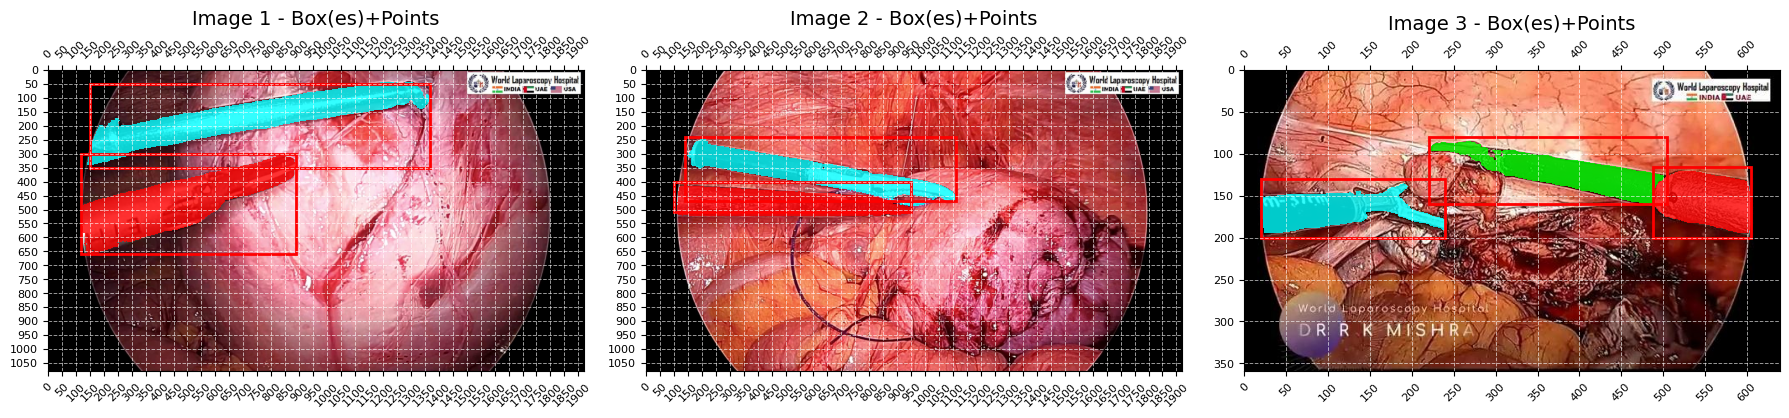

In [206]:
points_for_images = {

}
"""
selected_images[0]: {
        "coords": [[350, 230], [350, 520]],  # 2 foreground points
        "labels": [1, 1]
    },
    selected_images[1]: {
        "coords": [[330, 320], [280, 450], [750, 1020]],  # 3 points (could add background label)
        "labels": [1, 1, 0]  # last is background point
    },
    selected_images[2]: {
        "coords": [[90, 170], [560, 160], [360, 120]],  # 3 points (could add background label)
        "labels": [1, 1, 1]  # last is background point
    },
"""
boxes_for_images = {
    selected_images[0]: [
        np.array([150, 50, 1370, 350]), # xmin, ymin, xmax, ymax
        np.array([120, 300, 890, 660]),
    ],
    selected_images[1]: [
        np.array([140, 240, 1110, 470]),
        np.array([100, 400, 950, 510]),
    ],
    selected_images[2]: [  # no boxes example, can also be empty or [None]
        np.array([20, 130, 240, 200]),
        np.array([488, 115, 605, 200]),
        np.array([220, 80, 505, 160]),
    ],
}
# ✅ Run SAM with desired points and boxes
run_sam_with_points_and_boxes(selected_images, points_for_images, boxes_for_images, threshold=0.5, show_grid=True)

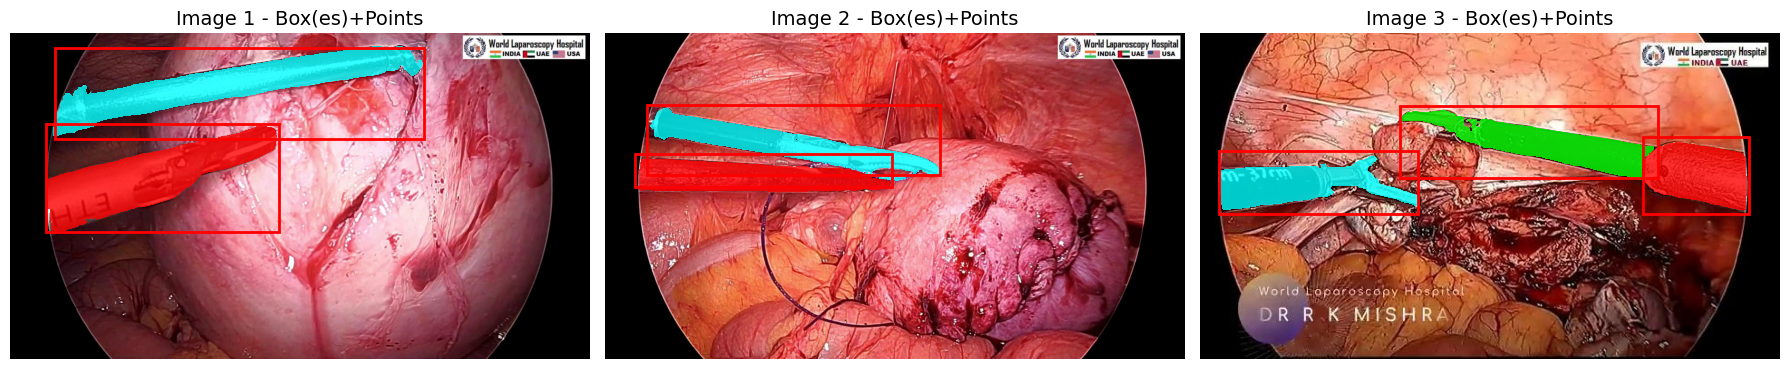

In [209]:
# ✅ Run SAM with desired points and boxes
run_sam_with_points_and_boxes(selected_images, points_for_images, boxes_for_images, threshold=0.5, show_grid=False)